# Efficient Estimation of Word Representations in Vector Space

_This notebook demonstrates the implementation of Word2Vec Skip-Gram architecture proposed by [Mikolov et al., 2013](https://arxiv.org/pdf/1301.3781.pdf) for learning continuous word representations._


**Note**: The notebook has been derived from my previously written blog post ([link](https://jaygala24.github.io/blog/python/pytorch/word-embeddings/word2vec/glove/2021/04/20/word_embeddings.html)).


Previously, neural language models involved the first stage as learning a distributed representation for words and using these representations in the later stages for obtaining prediction. The main idea of the word2vec is also based on these neural language models where we use the hidden layer of a neural network to learn continuous representations of words which we call embeddings. Here, we discard the output layer of a trained neural network. Word2Vec model presents two algorithms:
- Continuous Bag of Words (CBOW): Predict center word based on the context words.
- Skip Gram: Predict the context words based on the center word.



The figure below illustrates the two algorithms:

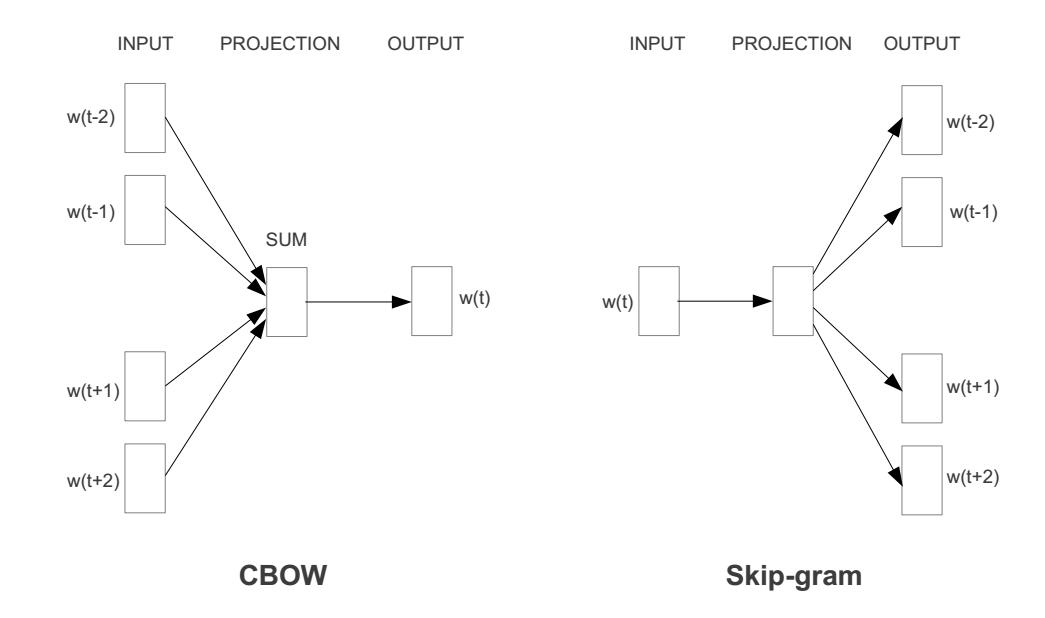

(source: https://arxiv.org/pdf/1301.3781.pdf)


Here we will be using text corpus of cleaned wikipedia articles provided by Matt Mahoney.


In [ ]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
!unzip text8.zip

### Imports


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import time
import random
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# check if gpu is available since training is faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Skip-Gram Model

From now onwards, we will look into the skip-gram model for word embeddings. The task is formulated as predicting the context words within a fixed window of size m given the center word. Visual illustration of above idea is shown below:


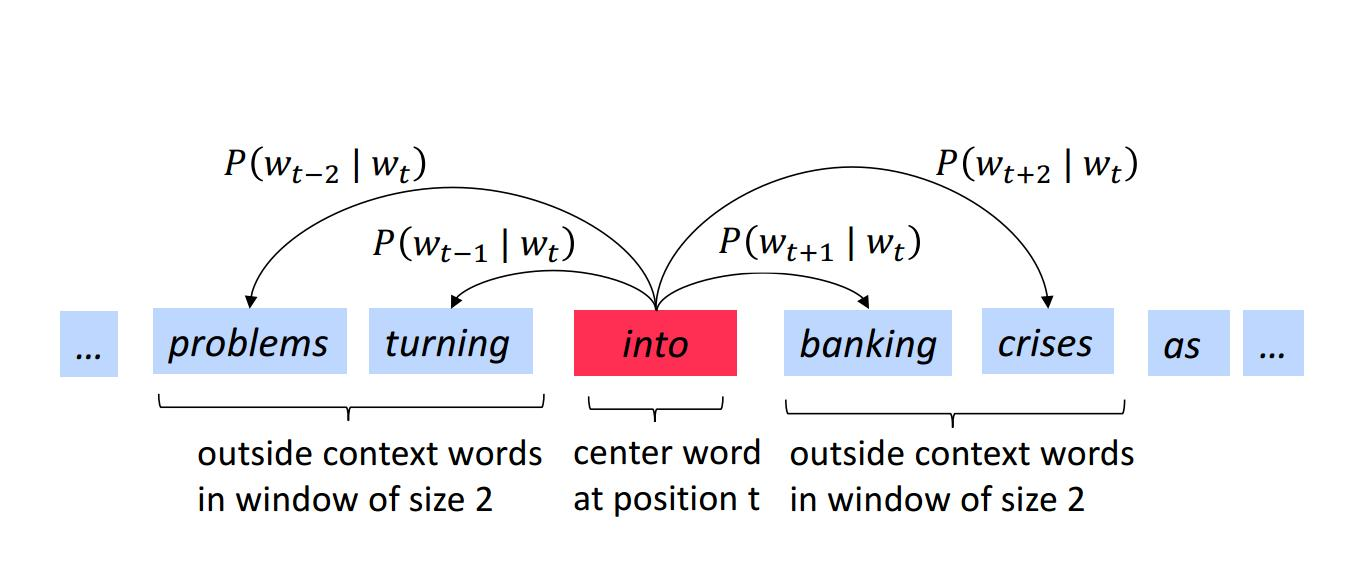

(image source: https://stanford.io/32wNQWe)


Word pairs from the large corpus of text for a fixed window size $m$ are used for training the neural network. These word pairs are formed by looking at a fixed window size $m$ before and after the center word. This window size is a hyperparameter that you can play around with, but the authors found that window size 5 seems to work well in general. Having a smaller window size means that you are capturing minimal context. On the other hand, if your window size is too large, you are capturing too much context, which might not help you obtain specific meanings. For the above example with window size 2, the training pairs would be the following:

```
    [(into, problems), (into, turning), (into, banking), (into, crises)]
```

Since every word is represented by a vector, so the objective is to iteratively maximize the probability of context words $o$ given the center word $c$ for each position $t$ and adjust the word vectors.

$$
L(\theta) = \prod_{t=1}^{T}\prod_{\substack{-m \leq j \leq m \\ j \neq 0}} P(w_{t+j}\ |\ w_t\ ;\ \theta)
$$

where $L$ is the likelihood estimation and $\theta$ is the vector representation to be optimized.

In order to avoid the floating-point overflow and simple gradient calculation, we take the apply logarithm to the above likelihood estimation. The cost function is given as follows:

$$
J(\theta) = - \frac{1}{T}\ log\ L(\theta) = - \frac{1}{T}\ \prod_{t=1}^{T}\prod_{\substack{-m \leq j \leq m \\ j \neq 0}} P(w_{t+j}\ |\ w_t\ ;\ \theta)
$$

Here we are minimizing the cost function, which means that we are maximizing the likelihood estimation, i.e., predictive accuracy.

Likelihood estimation for a context word $o$ given the center word $c$ is as follows:

$$
P(o\ |\ c) = \frac{exp(u_o^T v_c)}{\sum_{w \in V}\ exp(u_w^T v_c)}
$$

where
- $v_w$ and $u_w$ are the center word and context word vector representations
- $u_o^T v_c$ represents the dot product which is used as a similarity measure between context word $o$ and center word $c$
- $V$ represents the vocabulary

In order to express this similarity measure in terms of probability, we normalize over the entire vocabulary (the idea of using softmax) and $exp$ is used to quantify the dot product to a positive value.

Computing the normalizing factor for every word is too much expensive, which is why the authors came up with some tricks which reduce the computational cost and speed up the training.


#### Negative Sampling
 
The main idea of the negative sampling is to differentiate data from noise, i.e., train a binary logistic regression for classifying a true pair (center word and context word) against several noise pairs (center word and random word). So now our problem is reduced to $K + 1$ labels classification instead of $V$ words ($K \ll V$), which means that weights will only be updated for $K + 1$ words whereas weights for all the words were updated. In general, we choose 5 negative words other than the context window around the center word ($K = 5$). We want the context words to have a higher probability than the sampled negative words.
 
The new objective function (cost function) is given as follows:
 
$$
J_{neg-sample}(\theta) = -\ log\ (\sigma(u_o^T v_c)) - \sum_{k=1}^{K}\ log\ (\sigma(-u_k^T v_c))
$$
 
where
- $\sigma$ represents sigmoid
- first term represents the estimation for true pair
- second term represents the estimation for negative samples
 
The authors found that the unigram distribution $U(w)^{3/4}$ works well than the other unigram and uniform distribution choices for sampling noise. The intuition is that raised to $3/4$ factor brings down the probability for more frequent words.
 
$$
P_n(w) = \frac{U(w)^{3/4}}{Z}
$$
 
where $Z$ is the normalization term


#### Subsampling Frequent Words
 
Word2vec has been trained on a very large corpus of text in which frequently occurring words do not contribute significantly to the meaning of a word. Common function words such as "the", "as", "a" provide structure to the sentence but don’t help in learning good quality word representation as they occur in context with many words in the corpus. For example, the co-occurrence of "New", "York" benefits the model in capturing better meaningful representation than the co-occurrence of "New", "the". The authors introduce a subsampling technique that discards the high-frequency words based on the probability formula computed for each word $w_i$ which is given below:
 
$$
P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}
$$

where $t$ is a chosen threshold, typically around $10^{-5}$.


In [ ]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """ Skip Gram variant of Word2Vec with negative sampling for learning word 
            embeddings. Uses the concept of predicting context words given the 
            center word.
            Params:
                vocab_size (int): number of words in the vocabulary
                embed_dim (int): embeddings of dimension to be generated
        """
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # embedding layers for input (center) and output (context) words
        self.embed_in = nn.Embedding(vocab_size, embed_dim)
        self.embed_out = nn.Embedding(vocab_size, embed_dim)

        # initialize the embeddings with uniform dist
        self.embed_in.weight.data.uniform_(-1, 1)
        self.embed_out.weight.data.uniform_(-1, 1)


    def forward(self, in_ids, pos_out_ids, neg_out_ids):
        """ Trains the Skip Gram variant model and updates the weights based on the
            criterion.
            Params:
                in_ids (torch tensor of shape (batch_size,)): indexes of the input words for a batch
                pos_out_ids (torch tensor of shape (batch_size,)): indexes of the output words (true pairs) for a batch
                neg_out_ids (torch tensor of shape (batch_size, number of negative samples)): 
                    indexes of the noise words (negative pairs) for a batch
        """
        emb_in = self.embed_in(in_ids)
        pos_emb_out = self.embed_out(pos_out_ids)
        neg_emb_out = self.embed_out(neg_out_ids)

        # calculate loss for true pair
        # ----------------------------
        # step 1 is calculate the dot product between the input and output word embeddings
        pos_loss = torch.mul(pos_emb_out, emb_in)      # element-wise multiplication
        pos_loss = torch.sum(pos_loss, dim=1)           # sum the element-wise components
        
        # step 2 is to calculate the log sogmoid of dot product
        pos_loss = -F.logsigmoid(pos_loss)

        # calculate loss for negative pairs
        # ----------------------------------
        # step 1 is calculate the dot product between the input and output word embeddings
        neg_loss = torch.bmm(-neg_emb_out, emb_in.unsqueeze(2)).squeeze()   # matrix-matrix multiplication
        neg_loss = torch.sum(neg_loss, dim=1)                               # sum the element-wise components

        # step 2 is to calculate the log sogmoid of dot product
        neg_loss = -F.logsigmoid(neg_loss)

        return torch.mean(pos_loss + neg_loss)


### Data Preprocessing and Loading


In [ ]:
class Word2VecDataset(object):
    def __init__(self, corpus, min_count=5, window_size=5, threshold=1e-5):
        """ Prepares the training data for the word2vec neural network.
            Params:
                corpus (string): corpus of words
                min_count (int): words with minimum occurrence to consider
                window_size (int): context window size for generating word pairs
                threshold (float): threshold used for subsampling words
        """
        self.window_size = window_size
        self.min_count = min_count
        self.threshold = threshold

        tokens = corpus.split(" ")
        word_counts = Counter(tokens)
        # only consider the words that occur atleast 5 times in the corpus 
        word_counts = Counter({word:count for word, count in word_counts.items() if count >= min_count})
        
        self.word2idx = {word: idx for idx, (word, _) in enumerate(word_counts.most_common())}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        # create prob dist based on word frequency
        word_freq = np.array(list(word_counts.values()))
        self.unigram_dist = word_freq / word_freq.sum()

        # create prob dist for negative sampling
        self.noise_dist = self.unigram_dist ** 0.75
        self.noise_dist = self.noise_dist / self.noise_dist.sum()

        # get prob for drop words
        self.word_drop_prob = 1 - np.sqrt(threshold / word_freq)

        # create the training corpus subsampling frequent words
        self.token_ids = [self.word2idx[word] for word in tokens 
                          if word in self.word2idx and random.random() > self.word_drop_prob[self.word2idx[word]]]

        # create word pairs for corpus
        self.generate_word_pairs()
    

    def generate_word_pairs(self):
        """ Creates the pairs of center and context words based on the context window size.
        """
        word_pair_ids = []
        for current_idx, word_id in enumerate(self.token_ids):
            # find the start and end of context window
            left_boundary = max(current_idx - self.window_size, 0)
            right_boundary = min(current_idx + self.window_size + 1, len(self.token_ids))

            # obtain the context words and center words based on context window
            context_word_ids = self.token_ids[left_boundary:current_idx] + self.token_ids[current_idx + 1:right_boundary]
            center_word_id = self.token_ids[current_idx]
            
            # add the word pair to the training set
            for context_word_id in context_word_ids:
                word_pair_ids.append((center_word_id, context_word_id))
        
        self.word_pair_ids = word_pair_ids


    def get_batches(self, batch_size):
        """ Creates the batches for training the network.
            Params:
                batch_size (int): size of the batch
            Returns:
                batch (torch tensor of shape (batch_size, 2)): tensor of word pair ids for a given batch
        """
        for i in range(0, len(self.word_pair_ids), batch_size):
            yield torch.tensor(self.word_pair_ids[i: i+batch_size], dtype=torch.long)
    
    
    def get_negative_samples(self, batch_size, n_samples):
        """ Samples negative word ids for a given batch.
            Params:
                batch_size (int): size of the batch
                n_samples (int): number of negative samples
            Returns:
                neg_samples (torch tensor of shape (batch_size, n_samples)): tensor of negative sample word ids
                    for a given batch
        """
        neg_samples_ids = np.random.choice(len(self.word2idx), size=(batch_size, n_samples), 
                                       replace=False, p=self.noise_dist)
        return torch.tensor(neg_samples_ids, dtype=torch.long)


In [ ]:
# read the file and initialize the Word2VecDataset
with open("text8", encoding="utf-8") as f:
    corpus = f.read()

dataset = Word2VecDataset(corpus)

### Training


In [ ]:
# intialize the model and optimizer
vocab_size = len(dataset.word2idx)
embed_dim = 300
model = SkipGramModel(vocab_size, embed_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
# training the network
n_epochs = 5
n_neg_samples = 5
batch_size = 512

print("-" * 60)
print("Start of training")
print("-" * 60)

for epoch in range(n_epochs):
    losses = []
    start = time.time()

    for batch in dataset.get_batches(batch_size):
        # get the negative samples
        noise_word_ids = dataset.get_negative_samples(len(batch), n_neg_samples)

        # load tensor to GPU
        input_word_ids = batch[:, 0].to(device)
        target_word_ids = batch[:, 1].to(device)
        noise_word_ids = noise_word_ids.to(device)
        
        # forward pass
        loss = model.forward(input_word_ids, target_word_ids, noise_word_ids)

        # backward pass, optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    end = time.time()

    print(f"Epochs: {epoch + 1}/{n_epochs}\tAvg training loss: {np.mean(losses):.6f}\tEllapsed time: {(end - start):.0f} s")

print("-" * 60)
print("End of training")
print("-" * 60)


### Inference


In [ ]:
# get the trained embeddings from the model
embeddings = model.embed_in.weight.to("cpu").data.numpy()

# number of words to be visualized
viz_words = 200

# projecting the embedding dimension from 300 to 2
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

# plot the projected embeddings
plt.figure(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color="blue")
    plt.annotate(dataset.idx2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)


### References

1. [Efficient Estimation of Word Representations in Vector Space](http://arxiv.org/pdf/1301.3781.pdf)
2. [Distributed Representations of Words and Phrases and their Compositionality](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)
3. [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
4. [Word2Vec Tutorial Part 2 - Negative Sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)
5. [CS224N notes on Word2Vec](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/readings/cs224n-2019-notes01-wordvecs1.pdf)
6. [Implementation of Word2Vec Notebook by ashukr](https://www.kaggle.com/ashukr/implementation-of-word2vec-paper/notebook)
